# Object Detection using SSD-MobileNet V2

In [3]:
# Image Manipulation Packages
from PIL import Image
import io
import os
import base64
import time

# Object detection model
import tensorflow_hub as hub

# Helper Functions
from draw import BoundingBox, Rectangle
from model import ObjectDetection

### Load MobileNetV2 Model

In [4]:
# Load MobileNetV2 Object detection model
model = hub.load("https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1").signatures['default']
object_detection = ObjectDetection(model)

# Load a dummy image to initialize the model, otherwise first request of API call takes much more time
place_holder_img = Image.open(os.path.join('..', 'images', 'img_2.jpg'))
_ = object_detection.detect(place_holder_img, 10, 0.1)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


### Helper Function to Annotate Image with the Detected Boxes

In [3]:
def draw_boxes(base_image, detected_object_specs):    
    class_entities = detected_object_specs['detection_class_entities']
    scores = detected_object_specs['detection_scores']
    boxes = detected_object_specs['detection_boxes']
    
    # Start drawing the rectangles from having least score to highest score
    for i in range(scores.size-1, -1, -1):
        rectangle = Rectangle(*tuple(boxes[i]))
        predicted_class = class_entities[i].decode("ascii")
        display_str = "{}: {}%".format(predicted_class, int(100 * scores[i]))
        
        # Draw Bounding Box to the base image
        BoundingBox(base_image).draw_bounding_box_to_base_image(rectangle, predicted_class, thickness=5)
        
        # Draw Predicted Class to the base image
        BoundingBox(base_image).draw_predicted_class(rectangle, display_str)
    return base_image

### Dploy Annotations

In [6]:
# @dploy endpoint detect_objects
def get_detected_objects(image: bytes) -> dict:
    pil_image = Image.open(io.BytesIO(image))
    detected_objects = object_detection.detect(
        pil_image, max_n_object=5, min_score=0.15
    )
    return {
        'objects': [detected_object.decode('UTF-8') 
                    for detected_object in detected_objects['detection_class_entities'].tolist()],
        'scores': detected_objects['detection_scores'].tolist(),
        'detection_boxes': detected_objects['detection_boxes'].tolist(),
        'detection_class_labels': detected_objects['detection_class_labels'].tolist(),
    }


# @dploy endpoint annotated_image
def get_annotated_objects(image: bytes) -> bytes:
    pil_image = Image.open(io.BytesIO(image))
    detected_objects = object_detection.detect(pil_image)
    annotated_pil_image = draw_boxes(pil_image, detected_objects)
    img_byte_arr = io.BytesIO()
    annotated_pil_image.save(
        img_byte_arr, format=annotated_pil_image.format
    )
    img_byte_arr.seek(0)
    return img_byte_arr

## Testing

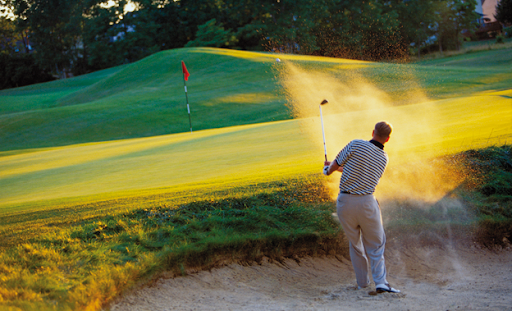

In [4]:
img = open("../images/golf.png", "rb").read()
get_annotated_objects(img)